# Import Libraries

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# import numpy as np
# print(np.__version__)

In [3]:
!pip install numpy==2.1.3

In [4]:
import numpy as np
print(np.__version__)

2.1.3


In [5]:
import pandas as pd
print(pd.__version__)

2.2.3


In [6]:
import random
import shutil
import tqdm
import glob
import os

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style("darkgrid")

In [8]:
from src.utils import float_to_int
from src.components.data_processing import data_processing

In [9]:
# Maximize column display 
pd.set_option("display.max_colwidth", None)     # Display all content within each cell without truncation
pd.set_option("display.max_columns", None)      # Display all columns
pd.set_option("display.width", None)            # Display entire width of DataFrame is displayed

pd.set_option("display.max_rows", None)         # Display all rows

# Load Data

In [10]:
def get_dates(dirpath: str, signal_id: str):
    """
    Retrieves a list of dates from the filepaths of .pkl files for a given signal ID.

    Parameters:
    -----------
    dirpath : str
        The directory path containing the data.
    signal_id : str
        The signal ID for which dates are to be extracted.

    Returns:
    --------
    list
        A list of dates extracted from the filenames of the .pkl files.

    Raises:
    -------
    FileNotFoundError
        If no .pkl files are found for the given signal ID.
    """
    # Step 1: Define the filepaths pattern for the given signal ID
    # The pattern will match all .pkl files in the specified directory for the signal ID
    filepaths = f"{dirpath}/{signal_id}/*.pkl"

    # Step 2: Use glob to get all matching file paths based on the pattern
    filepaths = [p for p in glob.glob(filepaths)]

    # Step 3: Check if any files exist for the given signal ID
    # If no files match the pattern, raise a FileNotFoundError with an appropriate message
    if not filepaths:
        raise FileNotFoundError(f"No files found for signal ID: {signal_id}")

    # Step 4: Extract the date portion from each filepath
    # Assume that filenames are in the format "<date>.pkl"
    # os.path.basename(filepath) extracts the filename from the full path
    # .split(".")[0] extracts the date part (before the ".pkl" extension)
    dates = [os.path.basename(filepath).split(".")[0] for filepath in filepaths]

    # Step 5: Return the list of extracted dates
    return dates

In [11]:
def load_and_merge_data(dirpath1: str, dirpath2: str, signal_id: str) -> pd.DataFrame:
    """
    Loads and merges two DataFrames for a given signal ID.

    Parameters:
    -----------
    dirpath1 : str
        The directory path containing the first set of data.
    dirpath2 : str
        The directory path containing the second set of data.
    signal_id : str
        The signal ID for which the data will be loaded and merged.

    Returns:
    --------
    pd.DataFrame
        The merged DataFrame containing data from both sources.

    Raises:
    -------
    FileNotFoundError
        If the files for the given signal ID and dates are mismatched or not found.
    Exception
        For any other errors encountered during processing.
    """
    try:
        # Step 1: Get the list of dates for the signal ID in both directories
        # This assumes a function `get_dates` exists that fetches dates for a given signal ID.
        dates1 = get_dates(dirpath=dirpath1, signal_id=signal_id)
        dates2 = get_dates(dirpath=dirpath2, signal_id=signal_id)

        # Step 2: Ensure the lists of dates are identical
        # If dates1 and dates2 don't match, raise a FileNotFoundError
        if dates1 != dates2:
            raise FileNotFoundError(f"Files to merge didn't match for signal ID: {signal_id}")

        # Step 3: Initialize an empty DataFrame to accumulate the merged data
        df = pd.DataFrame()

        # Step 4: Iterate through the list of dates to process files for each date
        for date in dates1:  # Note: dates2 can also be used since they are identical
            # Load the data for the current date from the first directory
            df1_date = pd.read_pickle(f"{dirpath1}/{signal_id}/{date}.pkl")

            # Load the data for the current date from the second directory
            df2_date = pd.read_pickle(f"{dirpath2}/{signal_id}/{date}.pkl")

            # Merge the two datasets using common columns
            # Common columns are assumed to include identifiers like "signalID", "cycleNo", etc.
            df_date = pd.merge(
                df1_date, df2_date,
                on=["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"]
            )

            # Append the merged data for the current date to the main DataFrame
            # `ignore_index=True` resets the index after concatenation
            df = pd.concat([df, df_date], axis=0, ignore_index=True)

        # Step 5: Return the final merged DataFrame
        return df

    except FileNotFoundError as fnf_error:
        # Handle case where files are not found or mismatched
        print(fnf_error)
        raise

    except Exception as e:
        # Handle any other exceptions and re-raise them for debugging
        print(f"Error occurred while loading and merging data: {e}")
        raise

In [12]:
def replace_and_filter_columns_with_mapping(df: pd.DataFrame, mapping: dict, keep_column_names: list) -> pd.DataFrame:
    """
    Replaces digits in column names based on a custom mapping and filters the DataFrame 
    to include renamed columns along with additional specified columns.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame whose column names need to be updated.
    mapping : dict
        A dictionary where keys are digits (as strings) and values are their replacements (e.g., {'1': 'L'}).
    keep_column_names : list
        A list of additional column names to include in the filtered DataFrame.

    Returns:
    --------
    pd.DataFrame
        A filtered DataFrame with updated column names and selected columns.
    """
    try:
        # Define a function to replace digits in column names based on the mapping
        def replace_digits_in_column(col_name):
            proc_col_name = ""
            for char in col_name:
                if char.isdigit() and char in mapping:  # Replace digits based on the mapping
                    proc_col_name += mapping[char]
                else:
                    proc_col_name += char  # Keep non-digit characters as is
            return proc_col_name

        # Replace column names based on the mapping
        dict_column_names = {col: replace_digits_in_column(col) for col in df.columns}
        dict_column_names = {key: val for key, val in dict_column_names.items() if key != val}
        df = df.rename(columns=dict_column_names)

        # Filter the columns to include renamed and additional columns
        keep_column_names = keep_column_names + [col for col in dict_column_names.values() if col in df.columns]
        df = df[keep_column_names]

        return df

    except Exception as e:
        print(f"Error occurred while replacing and filtering columns: {e}")
        raise

In [13]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the input DataFrame to create new features, transform data, and rename columns.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing signal cycle data.

    Returns:
    --------
    pd.DataFrame
        The processed DataFrame with additional features, updated values, and renamed columns.

    """
    try:

        # # Create "day" and "hour" features
        # df["day"] = df["cycleBegin"].dt.day  # Extract day from cycleBegin timestamp
        # df["hour"] = df["cycleBegin"].dt.hour  # Extract hour from cycleBegin timestamp

        # # Create "isWeekday" feature: 1 for weekdays (Mon-Fri), 0 for weekends (Sat-Sun)
        # df["isWeekday"] = df["cycleBegin"].dt.weekday.apply(lambda x: 0 if x >= 5 else 1)

        # Remove columns with red light running counts
        columns = [column for column in df.columns if "Cnt" not in column]
        df = df[columns]

        # Convert "Ratio" values to seconds
        for i in range(len(df)):
            cycle_length = df.at[i, "cycleLength"]

            for column in df.columns:
                if "Ratio" in column:  # Identify ratio columns
                    # Multiply the ratio by cycle length to get values in seconds
                    df.at[i, column] = cycle_length * df.at[i, column]

        # Rename columns by removing the word "Ratio"
        df = df.rename(columns=lambda x: x.replace("Ratio", "") if "Ratio" in x else x)

        return df

    except Exception as e:
        print(f"Error occurred while processing DataFrame: {e}")
        raise

In [14]:
signal_ids = ["1301", "1435", "1439"]

---

**Red Light Running By Left-Turning Vehicles**

---

In [15]:
# # Load and merge 
# df = pd.DataFrame()
# for signal_id in tqdm.tqdm(signal_ids):
#     tqdm.tqdm.write(f"Processing Signal ID: {signal_id}")

#     # Create a temporary folder
#     os.makedirs(f"../data/production/production/temp/{signal_id}", exist_ok=True)
    
#     # Load data
#     # Features: signal + occupancy
#     df_id = load_and_merge_data(dirpath1="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_signal/spat", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/occupancy", 
#                                 signal_id=signal_id)

#     for date in df_id["date"].unique():
#         df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")

#     # # Features: signal + occupancy + split failure
#     # df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#     #                             dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/split_failure", 
#     #                             signal_id=signal_id)

#     # for date in df_id["date"].unique():
#     #     df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")


#     # Features: signal + occupancy + red light running
#     df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/red_running", 
#                                 signal_id=signal_id)
    
#     # Remove temporary folder
#     shutil.rmtree("../data/production/production/temp")

#     # Specify the mapping for replacements
#     dict_mapping = {'1': 'L', '5': 'L'} # Left-turning phases

#     # Specify additional columns to include
#     keep_column_names = ["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"]
    
#     for key, val in dict_mapping.items():
#         # Replace and filter columns
#         df_phase = replace_and_filter_columns_with_mapping(df=df_id, 
#                                                            mapping={key: val}, 
#                                                            keep_column_names=keep_column_names)
        
#         df_phase = process_df(df=df_phase)
#         df_phase["key"] = key

#         df = pd.concat([df, df_phase], axis=0, ignore_index=True)

# df.to_csv("../data/production/production/left+thru/left.csv", index=False)

In [16]:
df_by_left = pd.read_csv("../data/production/production/left+thru/left.csv")

print(df_by_left.shape)
df_by_left.head(1)

(106464, 37)


,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,redClearanceRunningFlagPhaseL,redRunningFlagPhaseL,key
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,7.79976,5.49792,2.00376,67.49856,[3.9],3.9,3.9,3.9,0.0,[np.float64(3.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[25.7],25.7,25.7,25.7,0.0,[np.float64(25.7)],0.0,0.0,1


---

**Red Light Running By Through Vehicles**

---

In [17]:
# # Load and merge 
# df = pd.DataFrame()
# for signal_id in tqdm.tqdm(signal_ids):
#     tqdm.tqdm.write(f"Processing Signal ID: {signal_id}")

#     # Create a temporary folder
#     os.makedirs(f"../data/production/production/temp/{signal_id}", exist_ok=True)
    
#     # Load data
#     # Features: signal + occupancy
#     df_id = load_and_merge_data(dirpath1="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_signal/spat", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/occupancy", 
#                                 signal_id=signal_id)

#     for date in df_id["date"].unique():
#         df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")

#     # # Features: signal + occupancy + split failure
#     # df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#     #                             dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/split_failure", 
#     #                             signal_id=signal_id)

#     # for date in df_id["date"].unique():
#     #     df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")


#     # Features: signal + occupancy + red light running
#     df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/red_running", 
#                                 signal_id=signal_id)
    
#     # Remove temporary folder
#     shutil.rmtree("../data/production/production/temp")

#     # Specify the mapping for replacements
#     dict_mapping = {'6': 'T', '2': 'T'} # through phases

#     # Specify additional columns to include
#     keep_column_names = ["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"]
    
#     for key, val in dict_mapping.items():
#         # Replace and filter columns
#         df_phase = replace_and_filter_columns_with_mapping(df=df_id, 
#                                                            mapping={key: val}, 
#                                                            keep_column_names=keep_column_names)
        
#         df_phase = process_df(df=df_phase)
#         df_phase["key"] = key

#         df = pd.concat([df, df_phase], axis=0, ignore_index=True)

# df.to_csv("../data/production/production/left+thru/thru.csv", index=False)

In [18]:
df_by_thru = pd.read_csv("../data/production/production/left+thru/thru.csv")

print(df_by_thru.shape)
df_by_thru.head(1)

(106464, 37)


,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,redClearanceRunningFlagPhaseT,redRunningFlagPhaseT,key
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,38.502,11.00412,3.99924,29.30292,[1.9],1.9,1.9,1.9,0.0,[np.float64(1.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],0.0,0.0,6


## Red Light Running By (Left-Turning+Through) Vehicles

In [19]:
# Merge data -- (1, 6), (5, 2)

# df_by_left.info()
# df_by_thru.info()

df_by_left["key"] = df_by_left["key"].replace({1: 1, 5: 2})
df_by_thru["key"] = df_by_thru["key"].replace({6: 1, 2: 2})

df = pd.merge(df_by_left, df_by_thru, 
              on=["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength", "key"], 
              how="inner")

print(df.shape)
df.head(1)

(106464, 67)


,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,redClearanceRunningFlagPhaseL,redRunningFlagPhaseL,key,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,redClearanceRunningFlagPhaseT,redRunningFlagPhaseT
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,7.79976,5.49792,2.00376,67.49856,[3.9],3.9,3.9,3.9,0.0,[np.float64(3.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[25.7],25.7,25.7,25.7,0.0,[np.float64(25.7)],0.0,0.0,1,38.502,11.00412,3.99924,29.30292,[1.9],1.9,1.9,1.9,0.0,[np.float64(1.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],0.0,0.0


In [20]:
# df.info()

# Exploratory Data Analysis

---

**Missing Value**

---

In [21]:
df.isna().mean() * 100

signalID                              0.000000
cycleNo                               0.000000
date                                  0.000000
cycleBegin                            0.000000
cycleEnd                              0.000000
cycleLength                           0.000000
greenPhaseL                           0.000000
yellowPhaseL                          0.000000
redClearancePhaseL                    0.000000
redPhaseL                             0.000000
greenOccupancyPhaseL                  4.942516
greenMinOccupancyPhaseL               4.942516
greenMaxOccupancyPhaseL               4.942516
greenAvgOccupancyPhaseL               4.942516
greenStdOccupancyPhaseL               4.942516
greenSumListOccupancyPhaseL           4.942516
yellowOccupancyPhaseL                 4.942516
yellowMinOccupancyPhaseL              4.942516
yellowMaxOccupancyPhaseL              4.942516
yellowAvgOccupancyPhaseL              4.942516
yellowStdOccupancyPhaseL              4.942516
yellowSumList

In [22]:
df[pd.isna(df["greenOccupancyPhaseL"])].head(1)

,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,redClearanceRunningFlagPhaseL,redRunningFlagPhaseL,key,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,redClearanceRunningFlagPhaseT,redRunningFlagPhaseT
13376,1301,3,2024-01-29,2024-01-29 00:01:56.400,2024-01-29 00:03:30.300,93.9,34.99653,5.50254,2.00007,51.40086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,57.50436,5.50254,2.00007,28.90242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Missing Value Summary:**

- Error results from sensor failure.
- Error is <5%.

In [23]:
df = df.dropna()

print(df.isna().sum().sum())
df.shape

0


(101202, 67)

---

**Duplicates**

---

In [24]:
df.duplicated().sum()

np.int64(0)

## Target Feature

In [25]:
# Change dtype (float -- int)
for column in df.columns:
    if "RunningFlag" in column:
        df = df.copy()
        df[column] = float_to_int(df[[column]])

In [26]:
# Summary of (unintentional + intentional) red light running
data_processing.target_summary(df)

,featureName,Not Red Run (0),Red Run (1)
0,redClearanceRunningFlagPhaseL,95025,6177
1,redRunningFlagPhaseL,64075,37127
2,redClearanceRunningFlagPhaseT,91609,9593
3,redRunningFlagPhaseT,71408,29794


**(Unintentional) Red Light Running:**

- "redClearanceRunningFlagPhaseL" and "redClearanceRunningFlagPhaseT"

In [27]:
# Drop (intentional) red light running
df = df.drop(columns=["redRunningFlagPhaseL", "redRunningFlagPhaseT"])

In [28]:
# Compress (unintentional) red light running columns into target column
columns = ["redClearanceRunningFlagPhaseL", "redClearanceRunningFlagPhaseT"]

df["uRedRunningFlag"] = df[columns].apply(lambda row: 1 if (row == 1).any() else 0, 
                                          axis=1) # if any phase experience red light run

df = df.drop(columns=columns)
df.head(1)

,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,key,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,uRedRunningFlag
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,7.79976,5.49792,2.00376,67.49856,[3.9],3.9,3.9,3.9,0.0,[np.float64(3.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[25.7],25.7,25.7,25.7,0.0,[np.float64(25.7)],1,38.502,11.00412,3.99924,29.30292,[1.9],1.9,1.9,1.9,0.0,[np.float64(1.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],0


---

**Distribution of (Unintentional) Red Light Running**

---

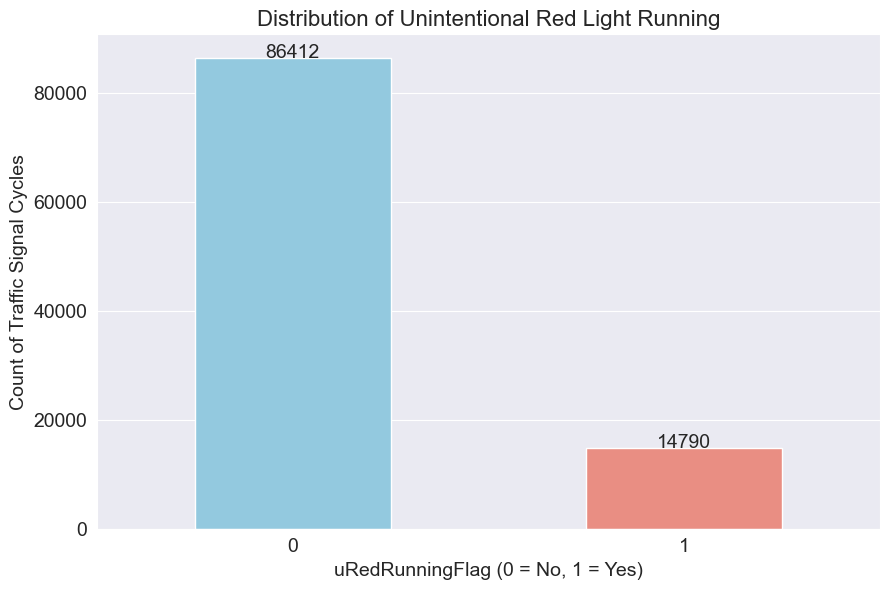

In [29]:
value_counts = df["uRedRunningFlag"].value_counts()

plt.figure(figsize=(9, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, 
            palette=["skyblue", "salmon"], 
            width=0.5)

plt.xlabel("uRedRunningFlag (0 = No, 1 = Yes)", fontsize=14)
plt.ylabel("Count of Traffic Signal Cycles", fontsize=14)
plt.title("Distribution of Unintentional Red Light Running", fontsize=16)
plt.xticks([0, 1])
# plt.xticks(ticks=[0, 1], labels=["No", "Yes"], fontsize=14)

# Setting font size for ticks
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

# Adding count labels on top of each bar
for index, value in enumerate(value_counts.values):
    plt.text(index, value + 0.25, str(value), ha="center", fontsize=14)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../reports/target_distribution.png", dpi=300)
plt.show()

---

**Hourly Trend of (Unintentional) Red Light Running per Signal**

---

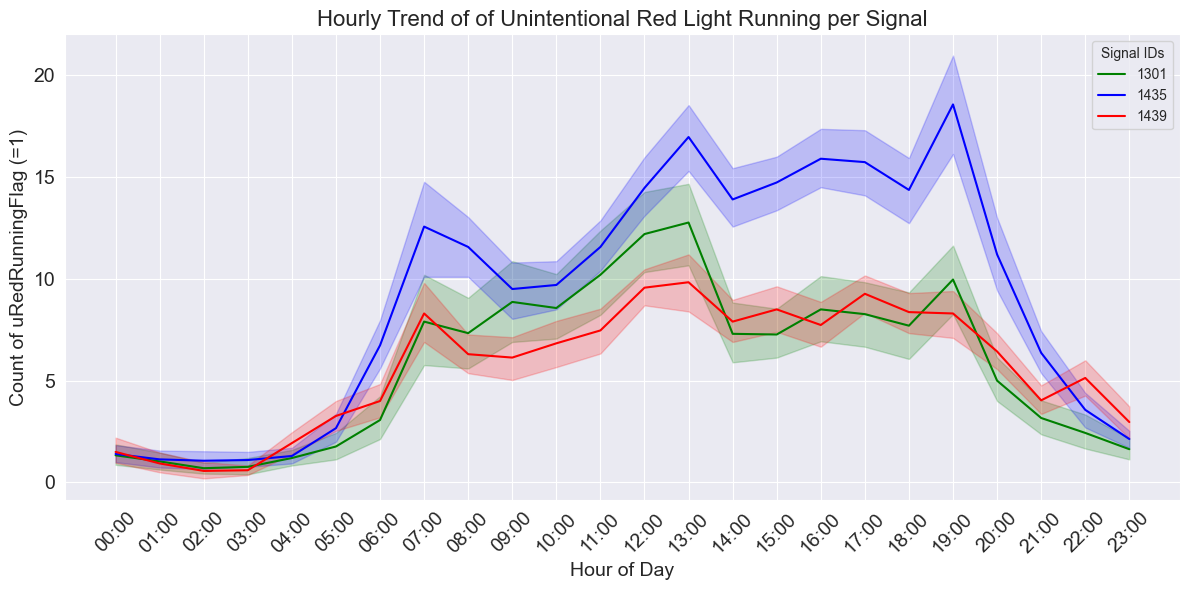

In [30]:
df["date"] = pd.to_datetime(df["date"]); df["cycleBegin"] = pd.to_datetime(df["cycleBegin"])
df["hour"] = df["cycleBegin"].dt.hour

df_hourly = df.copy()
df_hourly = (
    df_hourly.groupby(["signalID", "date", "hour"])[["signalID", "date", "hour", "uRedRunningFlag"]]
             .agg({"uRedRunningFlag": "sum"})
             .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hourly, 
             x="hour", y="uRedRunningFlag",
             hue="signalID",
             palette=["green", "blue", "red"],
             markers=True)

plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Count of uRedRunningFlag (=1)", fontsize=14)
plt.title("Hourly Trend of of Unintentional Red Light Running per Signal", fontsize=16)
plt.xticks(ticks=range(24), labels=[f"{hour:02d}:00" for hour in range(24)])

# Setting font size for ticks
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

plt.xticks(rotation=45)

plt.grid(True)
plt.legend(title="Signal IDs", fontsize=10, loc="upper right")

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../reports/target_hourly_trend.png", dpi=300)
plt.show()

## Independent Features

---

**Distribution of Cycle Length per (Unintentional) Red Light Running**

---

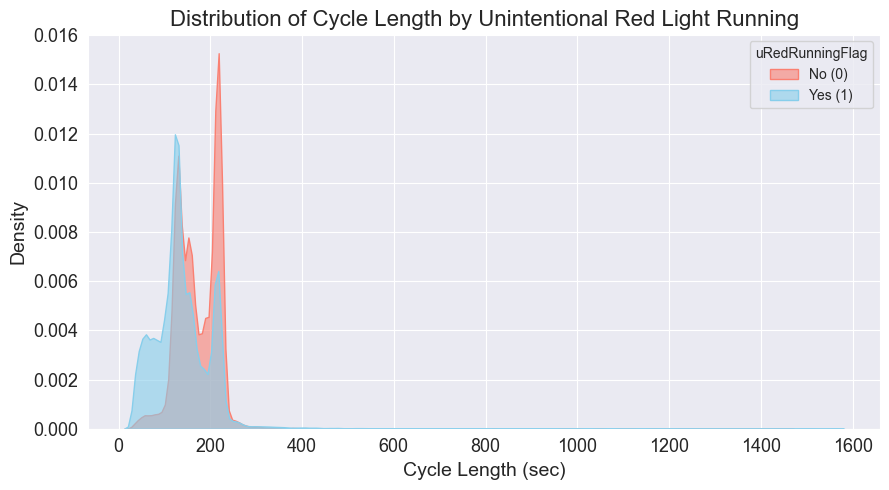

In [31]:
plt.figure(figsize=(9, 5))

# Using Seaborn's kdeplot for visualization
sns.kdeplot(
    data=df, 
    x="cycleLength", 
    hue="uRedRunningFlag", 
    fill=True, 
    common_norm=False,  # Allows each hue to have its own normalization
    palette=["skyblue", "salmon"], 
    alpha=0.6
)

plt.xlabel("Cycle Length (sec)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Distribution of Cycle Length by Unintentional Red Light Running", fontsize=16)
plt.legend(title="uRedRunningFlag", labels=["No (0)", "Yes (1)"])

# Setting font size for ticks
plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../reports/cycle_length_distribution.png", dpi=300)
plt.show()

---

**Trend of Traffic Signal Timinig (TST)**

---

In [32]:
# Get nearest "hour" from cycle begin
# df["timeHour"] = df["cycleBegin"].dt.ceil("H").dt.time

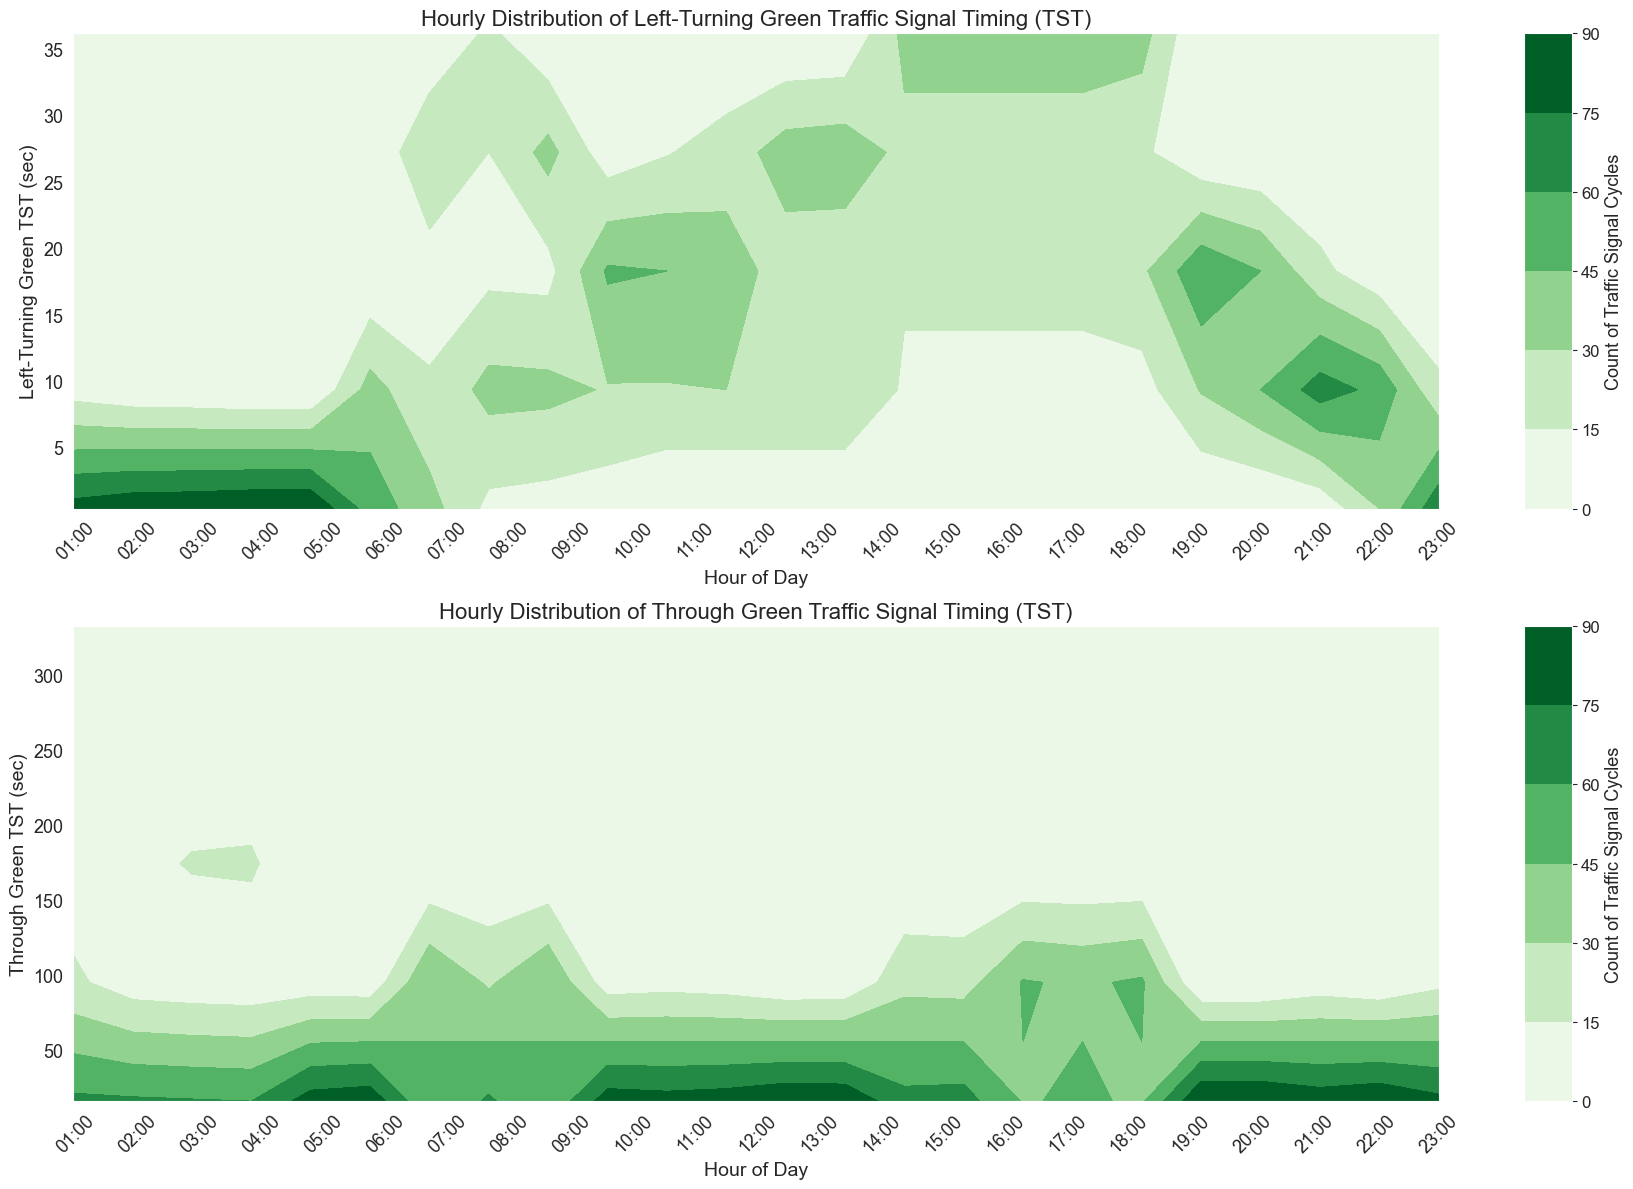

In [33]:
# Green TST
# Define the mapping dictionary
dict_map = {
    "L": "Left-Turning", 
    "T": "Through"
}

# Create subplots with (2, 1) configuration
fig, axes = plt.subplots(2, 1, figsize=(18, 12))  # 2 rows, 1 column, shared figure size

# Loop through each type of traffic signal (Left-Turning and Through)
for idx, (k, v) in enumerate(dict_map.items()):
    df_hourly = df.copy()
    df_hourly = (
        df_hourly.groupby(["signalID", "date", "hour"])
        .agg({f"greenPhase{k}": "mean"})  # Aggregate to mean 
        .reset_index()
    )
    
    # Compute 2D histogram for the heatmap
    heatmap, xedges, yedges = np.histogram2d(
        df_hourly["hour"], df_hourly[f"greenPhase{k}"], bins=[24, 5]
    )  

    # Create a contour plot in the respective subplot axis
    contour = axes[idx].contourf(xedges[1:], yedges[:-1], heatmap.T, cmap="Greens")
    
    # Add a colorbar for each subplot
    cbar = fig.colorbar(contour, ax=axes[idx], shrink=1, aspect=10)
    cbar.set_label("Count of Traffic Signal Cycles", fontsize=13)
    cbar.ax.tick_params(labelsize=12)

    # Add labels and formatting for each subplot
    axes[idx].set_xlabel("Hour of Day", fontsize=14)
    axes[idx].set_ylabel(f"{v} Green TST (sec)", fontsize=14)
    axes[idx].set_title(f"Hourly Distribution of {v} Green Traffic Signal Timing (TST)", fontsize=16)
    
    # Set custom ticks for the X-axis
    axes[idx].set_xticks(ticks=range(24))
    axes[idx].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)

    # Adjust Y-axis limits for better visualization
    axes[idx].set_xlim(xedges[1], xedges[-1])
    axes[idx].set_ylim(yedges[0], yedges[-2])


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

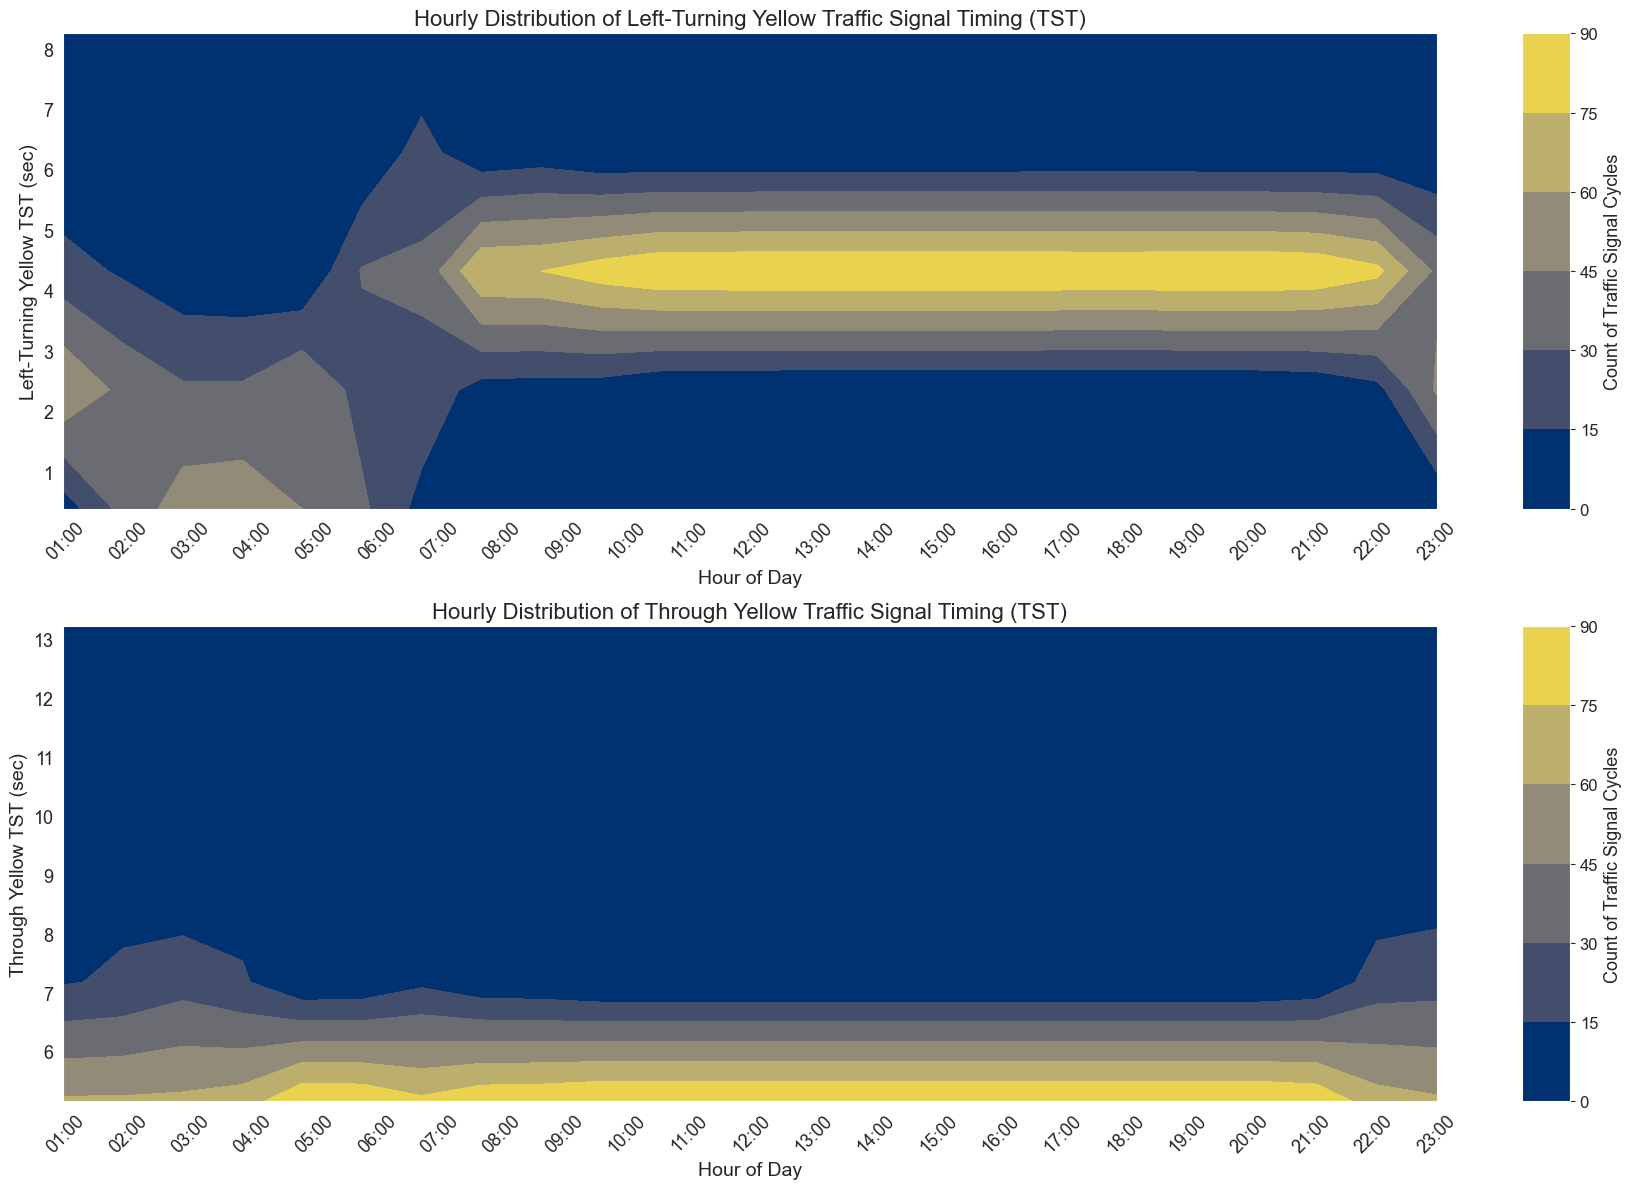

In [34]:
# Yellow TST
# Define the mapping dictionary
dict_map = {
    "L": "Left-Turning", 
    "T": "Through"
}

# Create subplots with (2, 1) configuration
fig, axes = plt.subplots(2, 1, figsize=(18, 12))  # 2 rows, 1 column, shared figure size

# Loop through each type of traffic signal (Left-Turning and Through)
for idx, (k, v) in enumerate(dict_map.items()):
    df_hourly = df.copy()
    df_hourly = (
        df_hourly.groupby(["signalID", "date", "hour"])
        .agg({f"yellowPhase{k}": "mean"})  # Aggregate to mean 
        .reset_index()
    )
    
    # Compute 2D histogram for the heatmap
    heatmap, xedges, yedges = np.histogram2d(
        df_hourly["hour"], df_hourly[f"yellowPhase{k}"], bins=[24, 5]
    )  

    # Create a contour plot in the respective subplot axis
    contour = axes[idx].contourf(xedges[1:], yedges[:-1], heatmap.T, cmap="cividis")
    
    # Add a colorbar for each subplot
    cbar = fig.colorbar(contour, ax=axes[idx], shrink=1, aspect=10)
    cbar.set_label("Count of Traffic Signal Cycles", fontsize=13)
    cbar.ax.tick_params(labelsize=12)

    # Add labels and formatting for each subplot
    axes[idx].set_xlabel("Hour of Day", fontsize=14)
    axes[idx].set_ylabel(f"{v} Yellow TST (sec)", fontsize=14)
    axes[idx].set_title(f"Hourly Distribution of {v} Yellow Traffic Signal Timing (TST)", fontsize=16)
    
    # Set custom ticks for the X-axis
    axes[idx].set_xticks(ticks=range(24))
    axes[idx].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)

    # Adjust Y-axis limits for better visualization
    axes[idx].set_xlim(xedges[1], xedges[-1])
    axes[idx].set_ylim(yedges[0], yedges[-2])


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

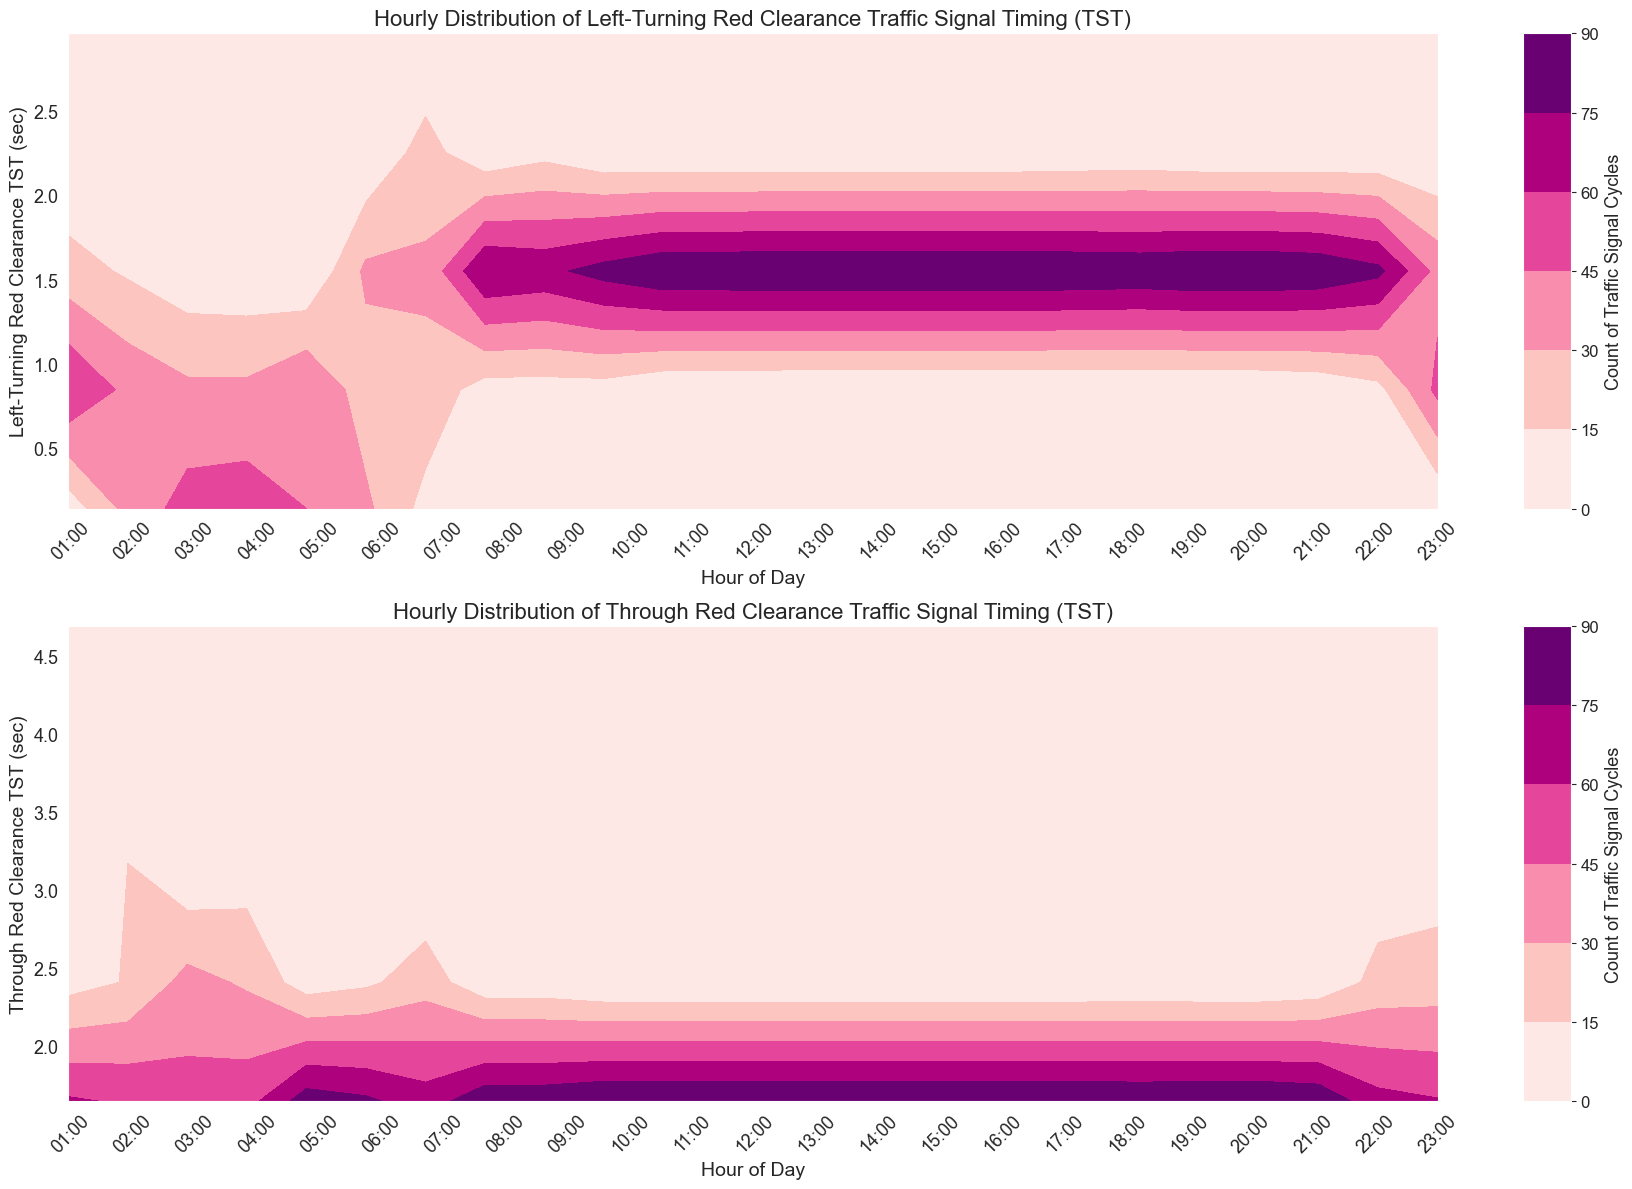

In [35]:
# Red Clearance TST
# Define the mapping dictionary
dict_map = {
    "L": "Left-Turning", 
    "T": "Through"
}

# Create subplots with (2, 1) configuration
fig, axes = plt.subplots(2, 1, figsize=(18, 12))  # 2 rows, 1 column, shared figure size

# Loop through each type of traffic signal (Left-Turning and Through)
for idx, (k, v) in enumerate(dict_map.items()):
    df_hourly = df.copy()
    df_hourly = (
        df_hourly.groupby(["signalID", "date", "hour"])
        .agg({f"redClearancePhase{k}": "mean"})  # Aggregate to mean 
        .reset_index()
    )
    
    # Compute 2D histogram for the heatmap
    heatmap, xedges, yedges = np.histogram2d(
        df_hourly["hour"], df_hourly[f"redClearancePhase{k}"], bins=[24, 5]
    )  

    # Create a contour plot in the respective subplot axis
    contour = axes[idx].contourf(xedges[1:], yedges[:-1], heatmap.T, cmap="RdPu")
    
    # Add a colorbar for each subplot
    cbar = fig.colorbar(contour, ax=axes[idx], shrink=1, aspect=10)
    cbar.set_label("Count of Traffic Signal Cycles", fontsize=13)
    cbar.ax.tick_params(labelsize=12)

    # Add labels and formatting for each subplot
    axes[idx].set_xlabel("Hour of Day", fontsize=14)
    axes[idx].set_ylabel(f"{v} Red Clearance TST (sec)", fontsize=14)
    axes[idx].set_title(f"Hourly Distribution of {v} Red Clearance Traffic Signal Timing (TST)", fontsize=16)
    
    # Set custom ticks for the X-axis
    axes[idx].set_xticks(ticks=range(24))
    axes[idx].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)

    # Adjust Y-axis limits for better visualization
    axes[idx].set_xlim(xedges[1], xedges[-1])
    axes[idx].set_ylim(yedges[0], yedges[-2])


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

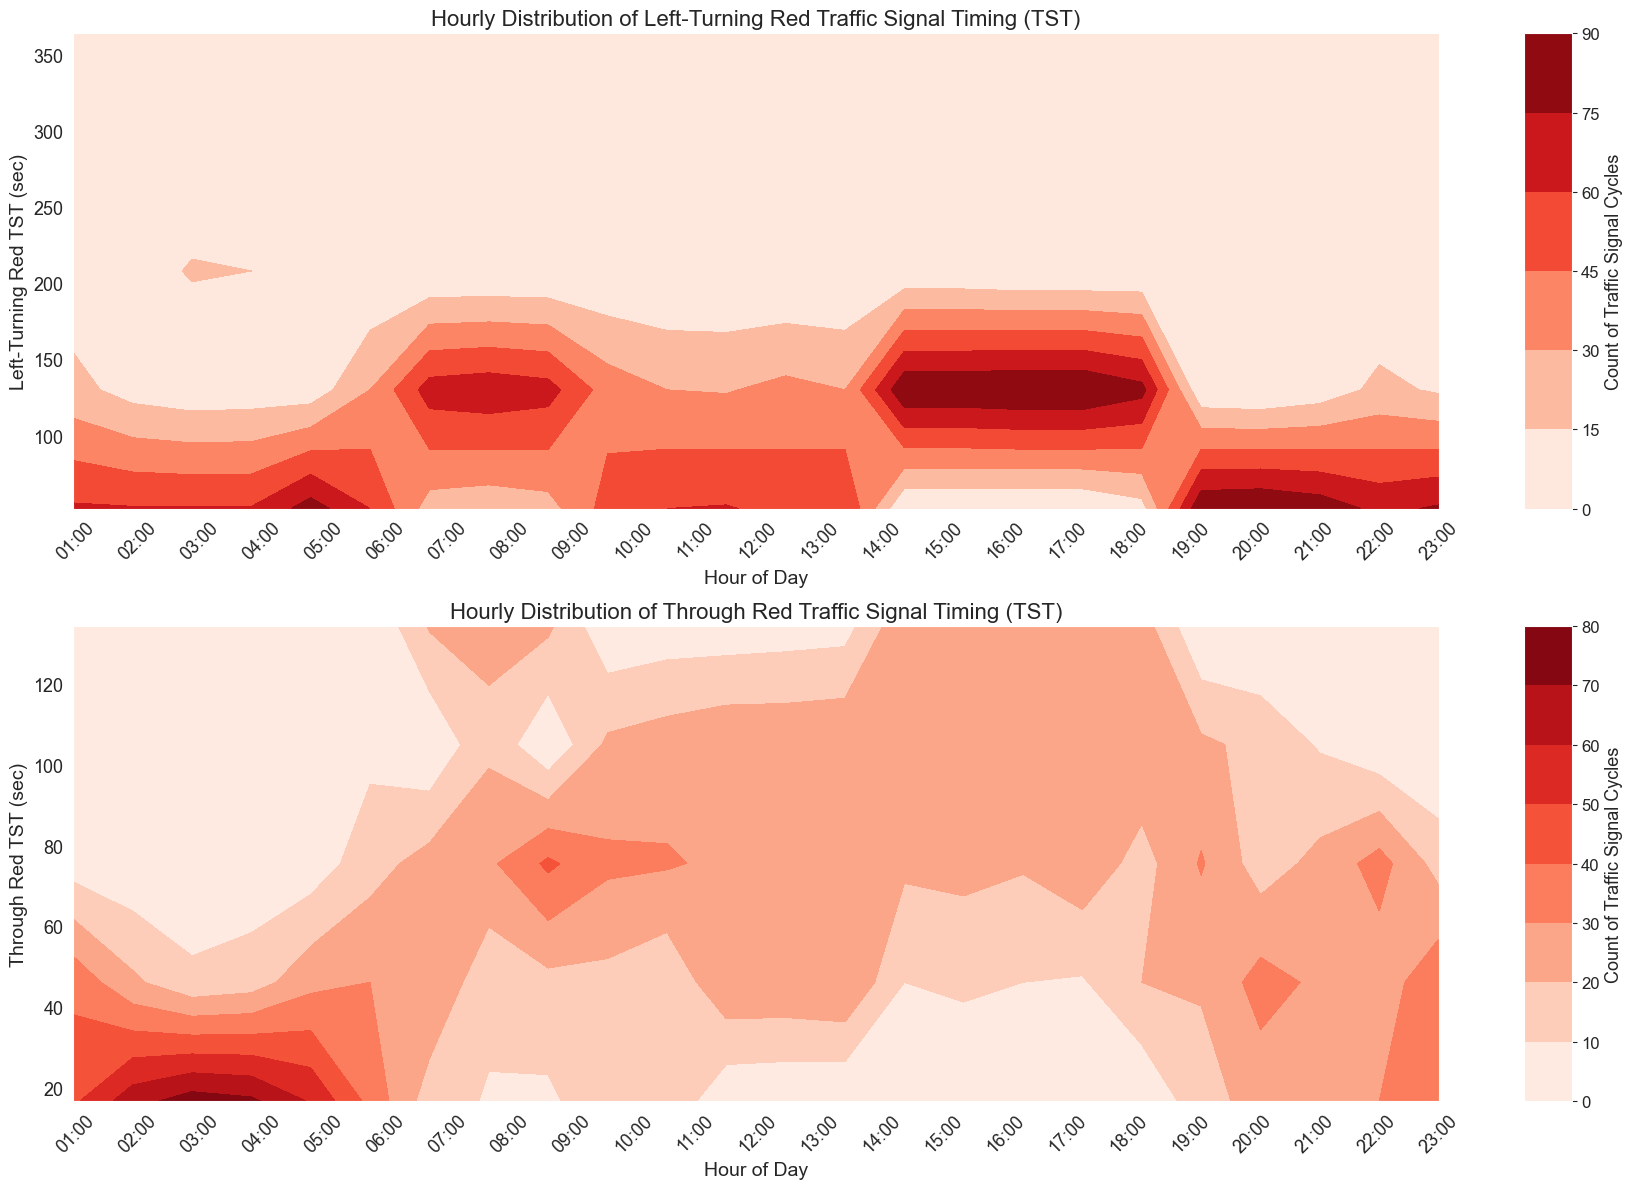

In [36]:
# Red TST
# Define the mapping dictionary
dict_map = {
    "L": "Left-Turning", 
    "T": "Through"
}

# Create subplots with (2, 1) configuration
fig, axes = plt.subplots(2, 1, figsize=(18, 12))  # 2 rows, 1 column, shared figure size

# Loop through each type of traffic signal (Left-Turning and Through)
for idx, (k, v) in enumerate(dict_map.items()):
    df_hourly = df.copy()
    df_hourly = (
        df_hourly.groupby(["signalID", "date", "hour"])
        .agg({f"redPhase{k}": "mean"})  # Aggregate to mean 
        .reset_index()
    )
    
    # Compute 2D histogram for the heatmap
    heatmap, xedges, yedges = np.histogram2d(
        df_hourly["hour"], df_hourly[f"redPhase{k}"], bins=[24, 5]
    )  

    # Create a contour plot in the respective subplot axis
    contour = axes[idx].contourf(xedges[1:], yedges[:-1], heatmap.T, cmap="Reds")
    
    # Add a colorbar for each subplot
    cbar = fig.colorbar(contour, ax=axes[idx], shrink=1, aspect=10)
    cbar.set_label("Count of Traffic Signal Cycles", fontsize=13)
    cbar.ax.tick_params(labelsize=12)

    # Add labels and formatting for each subplot
    axes[idx].set_xlabel("Hour of Day", fontsize=14)
    axes[idx].set_ylabel(f"{v} Red TST (sec)", fontsize=14)
    axes[idx].set_title(f"Hourly Distribution of {v} Red Traffic Signal Timing (TST)", fontsize=16)
    
    # Set custom ticks for the X-axis
    axes[idx].set_xticks(ticks=range(24))
    axes[idx].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)

    # Adjust Y-axis limits for better visualization
    axes[idx].set_xlim(xedges[1], xedges[-1])
    axes[idx].set_ylim(yedges[0], yedges[-2])


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---

**Boxplot of Occupancy**

---

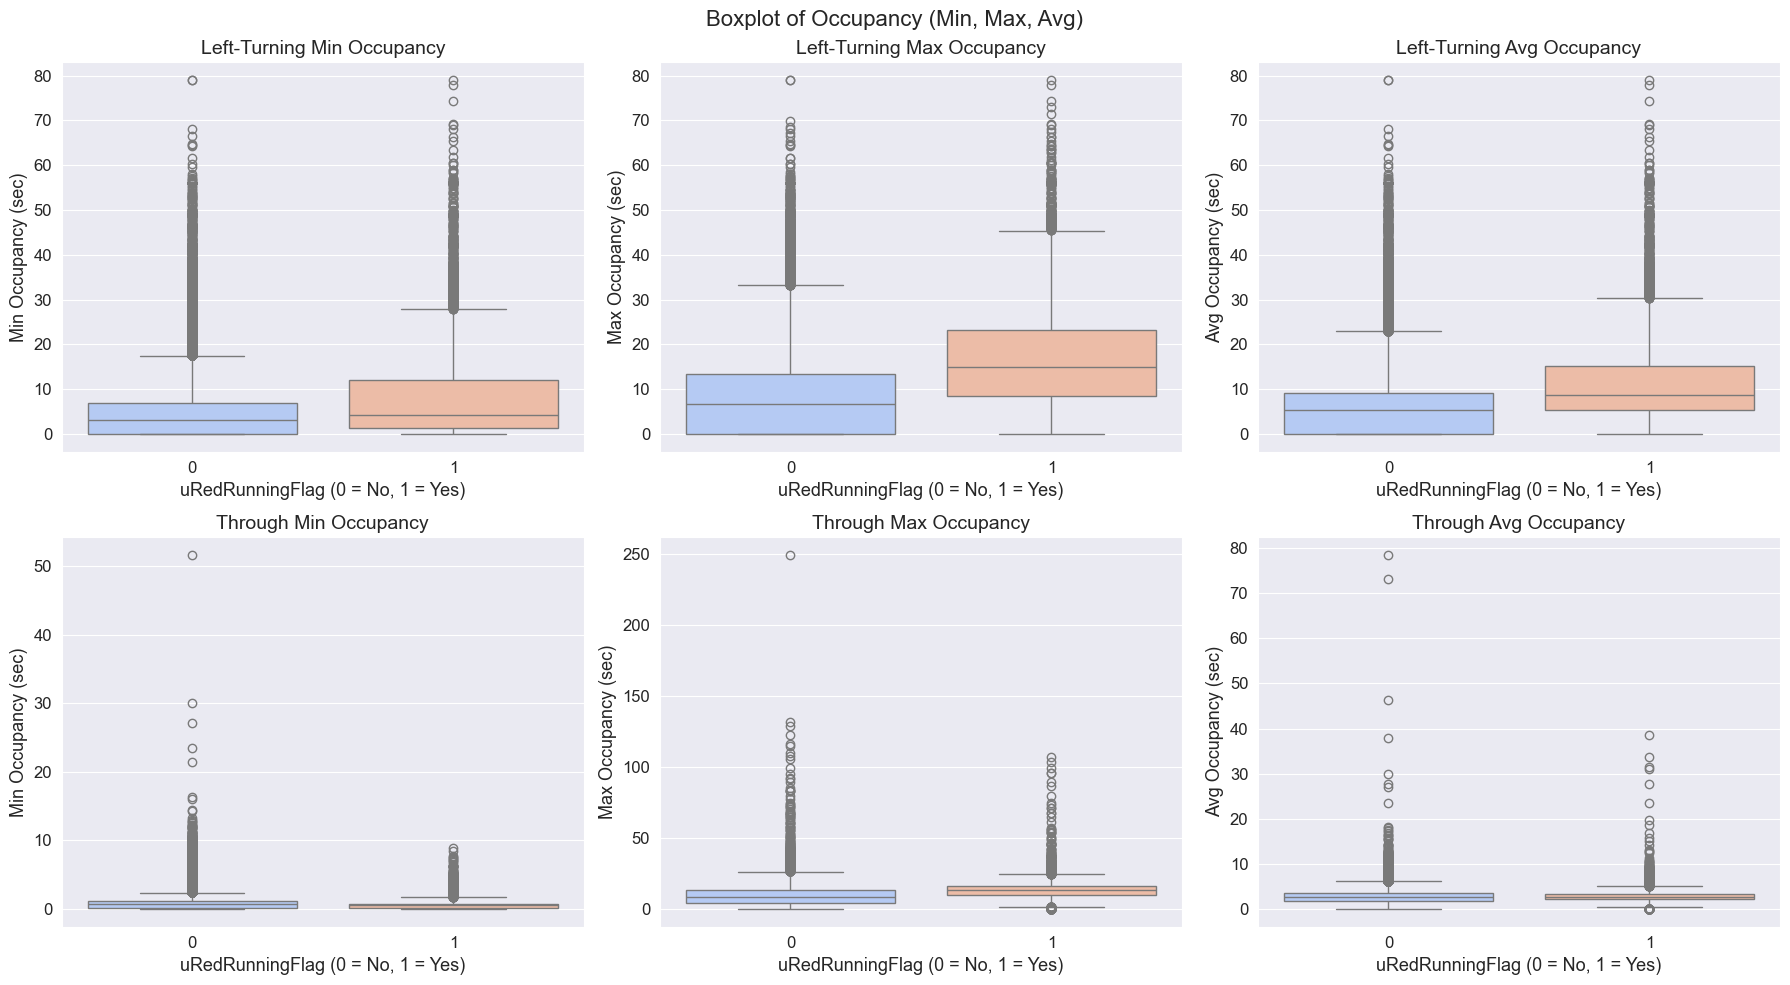

In [37]:
# Green Occupancy
# Define the mapping dictionary
dict_map = {
    "L": "Left-Turning", 
    "T": "Through"
}
types = ["Min", "Max", "Avg"]

# Create subplots with (2, 3) configuration
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Loop over rows and columns to populate the subplots
for row_idx, (k, v) in enumerate(dict_map.items()):
    for col_idx, t in enumerate(types):
        # Access the current subplot axis
        ax = axes[row_idx, col_idx]
        
        # Draw the boxplot
        sns.boxplot(
            data=df, 
            y=f"green{t}OccupancyPhase{k}", 
            x="uRedRunningFlag", 
            ax=ax, 
            palette="coolwarm"
        )
        
        # Add titles and labels
        ax.set_title(f"{v} {t} Occupancy", fontsize=14)
        ax.set_xlabel("uRedRunningFlag (0 = No, 1 = Yes)", fontsize=13)
        ax.set_ylabel(f"{t} Occupancy (sec)", fontsize=13)
        
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

plt.suptitle("Boxplot of Occupancy (Min, Max, Avg)", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Data Preparation

In [38]:
# Drop columns
for column in df.columns:
    for signal_type in ["green", "yellow", "redClearance", "red"]:
        if (f"{signal_type}OccupancyPhase" in column) or (f"{signal_type}SumListOccupancyPhase" in column):
            df = df.drop(columns=column)

In [39]:
# Create "day" feature
df["day"] = df["cycleBegin"].dt.day

# Create feature "isWeekday": 1 for weekday (Mon-Fri), 0 for weekend (Sat-Sun)
df["isWeekday"] = df["cycleBegin"].dt.weekday.apply(lambda x: 0 if x >= 5 else 1)

In [40]:
# Function to split time series data
def split_df(df: pd.DataFrame, train_ratio: float = 0.7, test_ratio: float = 0.2):
    # Sample dates considering weekend and weekday
    dict_dates = {
        "weekend_dates": df[df["isWeekday"] == 0]["date"].unique().tolist(),
        "weekday_dates": df[df["isWeekday"] == 1]["date"].unique().tolist(),
    }
    
    # Get train and export
    train_dates = []; valid_dates = []; test_dates = []
    for key in dict_dates.keys():
        random.seed(6)
        dates = dict_dates[key]
        train_dates = train_dates + random.sample(dates, int(np.ceil(len(dates) * train_ratio)))
        
        dates = list(set(dates).difference(set(train_dates)))
        test_dates = test_dates + random.sample(dates, int(np.ceil(len(dates) * (test_ratio / (1 - train_ratio)))))
    
        dates = list(set(dates).difference(set(test_dates)))
        valid_dates = valid_dates + dates
        
    # Get train, valid, and test dfs
    df_train = (
        df[df.date.isin(train_dates)].reset_index(drop=True)
    )
    df_valid = (
        df[df.date.isin(valid_dates)].reset_index(drop=True)
    )
    df_test = (
        df[df.date.isin(test_dates)].reset_index(drop=True)
    )

    return df_train, df_valid, df_test

In [41]:
df_train, df_valid, df_test = split_df(df=df)

# Feature Engineering

## Time Decomposition

In [42]:
def decompose_time(df: pd.DataFrame, rolling_window: int = 2):
    # Detemine sequence id 
    df = (
        df.groupby(["signalID", "date"])
          .apply(lambda group: group.assign(sequenceNo=(group["cycleNo"].diff() > 1).cumsum() + 1), include_groups=False)
          .reset_index() 
          .drop(columns=["level_2"], errors="ignore")
    )

    # Caculate lag (of previous two cycles)
    columns = ["cycleLength", 
               "greenPhaseL", "yellowPhaseL", "redClearancePhaseL", "redPhaseL", 
               "greenPhaseT", "yellowPhaseT", "redClearancePhaseT", "redPhaseT"]
    
    for column in columns:
        df = (
            df.groupby(["signalID", "date", "sequenceNo"])
              .apply(lambda group: group.assign(
                       **{
                           f"{column}Lag1": group[column].shift(1),
                           f"{column}Lag2": group[column].shift(2),
                       }
                    ), include_groups=False)
              .reset_index()
              .drop(columns=["level_3"], errors="ignore")
        )

    # Rolling average and standard deviation (with previous cycles)
    columns = [column for column in df.columns if "Occupancy" in column]
    
    for column in columns:
        df = (
            df.groupby(["signalID", "date", "sequenceNo"])
              .apply(lambda group: group.assign(
                       **{
                           f"{column}RollAvg{rolling_window}": group[column].rolling(window=rolling_window).mean(),
                           f"{column}RollStd{rolling_window}": group[column].rolling(window=rolling_window).std(),
                       }
                    ), include_groups=False)
              .reset_index()
              .drop(columns=["level_3"], errors="ignore")
        )

    # Cyclic decomposition of hour
    df["hourSin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hourCos"] = np.cos(2 * np.pi * df["hour"] / 24)

    return df

In [43]:
# Time decomposition
df_train, df_valid, df_test = decompose_time(df=df_train), decompose_time(df=df_valid), decompose_time(df=df_test)

## 1-Stepping Target Feature

In [44]:
df_train = (
    df_train.groupby(["signalID", "date", "sequenceNo"])
            .apply(lambda group: group.assign(uRedRunningFlagLead1=group["uRedRunningFlag"].shift(-1)), include_groups=False)
            .reset_index()
            .drop(columns=["level_3"], errors="ignore")
)
df_train["uRedRunningFlagLead1"] = float_to_int(df_train[["uRedRunningFlagLead1"]])

df_valid = (
    df_valid.groupby(["signalID", "date", "sequenceNo"])
            .apply(lambda group: group.assign(uRedRunningFlagLead1=group["uRedRunningFlag"].shift(-1)), include_groups=False)
            .reset_index()
            .drop(columns=["level_3"], errors="ignore")
)
df_valid["uRedRunningFlagLead1"] = float_to_int(df_valid[["uRedRunningFlagLead1"]])

df_test = (
    df_test.groupby(["signalID", "date", "sequenceNo"])
           .apply(lambda group: group.assign(uRedRunningFlagLead1=group["uRedRunningFlag"].shift(-1)), include_groups=False)
           .reset_index()
           .drop(columns=["level_3"], errors="ignore")
)
df_test["uRedRunningFlagLead1"] = float_to_int(df_test[["uRedRunningFlagLead1"]])

## Drop and Export

---

**Drop NAs**

---

In [45]:
df_train = df_train.dropna(); df_valid = df_valid.dropna(); df_test = df_test.dropna()

In [46]:
print("Distribution of Target in Train Data:")
print(f'{data_processing.target_summary(df=df_train)}\n')

print("Distribution of Target in Valid Data:")
print(f'{data_processing.target_summary(df=df_valid)}\n')

print('Distribution of Target in Test Data:')
print(data_processing.target_summary(df=df_test))

Distribution of Target in Train Data:
            featureName  Not Red Run (0)  Red Run (1)
0       uRedRunningFlag            63911        10651
1  uRedRunningFlagLead1            63907        10655

Distribution of Target in Valid Data:
            featureName  Not Red Run (0)  Red Run (1)
0       uRedRunningFlag             6135          983
1  uRedRunningFlagLead1             6138          980

Distribution of Target in Test Data:
            featureName  Not Red Run (0)  Red Run (1)
0       uRedRunningFlag            15217         2985
1  uRedRunningFlagLead1            15229         2973


---

**Drop Irrelevant Columns**

---

In [47]:
# df_train.columns.values

In [48]:
columns_to_drop = [
    "sequenceNo", "cycleBegin", "cycleEnd", "key", "day"
]

In [49]:
df_train = (
    df_train.drop(columns=columns_to_drop)
)
df_valid = (
    df_valid.drop(columns=columns_to_drop)
)
dff_test = (
    df_test.drop(columns=columns_to_drop)
)

---

**Export**

---

In [50]:
df_train = (
    df_train.reset_index(drop=True)
            .to_csv("../data/production/production/train+valid+test/train.csv", index=False)
)
df_valid = (
    df_valid.reset_index(drop=True)
            .to_csv("../data/production/production/train+valid+test/valid.csv", index=False)
)
df_test = (
    df_test.reset_index(drop=True)
           .to_csv("../data/production/production/train+valid+test/test.csv", index=False)
)

In [ ]:
X_train = df_train.drop(columns="uRedRunningFlag")
y_train = df_train["uRedRunningFlag"]

X_valid = df_valid.drop(columns="uRedRunningFlag")
y_valid = df_valid["uRedRunningFlag"]

X_test = df_test.drop(columns="uRedRunningFlag")
y_test = df_test["uRedRunningFlag"]

In [ ]:
# Create hour", and "day" features
df_data["day"] = df_data["cycleBegin"].dt.day

# Create feature "isWeekday": 1 for weekday (Mon-Fri), 0 for weekend (Sat-Sun)
df_data["isWeekday"] = df_data["cycleBegin"].dt.weekday.apply(lambda x: 0 if x >= 5 else 1)

In [ ]:
df_data.head(1)

In [ ]:
# Convert ratio to seconds
for i in tqdm.tqdm(range(len(df_data))):
    cycle_length = df_data.at[i, "cycleLength"]

    for column in df_data.columns:
        if "Ratio" in column:
            df_data.at[i, column] = cycle_length * df_data.at[i, column]


# Rename columns that contain 'Ratio' by removing the word 'Ratio'
df_data = df_data.rename(columns=lambda x: x.replace("Ratio", "") if "Ratio" in x else x)

In [ ]:
columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# Creating a figure for Seaborn boxplots
plt.figure(figsize=(20, 10))

# Using Seaborn's boxplot function to visualize outliers
sns.boxplot(data=df_data[columns], color="salmon")

plt.title("Outlier Detection", fontsize=20)
plt.xlabel("Signal Phases", fontsize=18)
plt.ylabel("Duration (seconds)", fontsize=18)
plt.xticks(rotation=90)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.tight_layout()
plt.savefig("../report/feature_distribution.png", dpi=300)
plt.show()

In [ ]:
# # Applying the IQR method to filter out outliers for each column in the dataset.
# def remove_outliers(df, columns):
#     # Create a copy of the DataFrame to avoid modifying the original data
#     proc_df = df.copy()

#     # Cutoffs
#     cutoffs = []
    
#     # Loop through each column to calculate IQR and filter out outliers
#     for column in columns:
#         # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1

#         # Define lower and upper bounds for outlier detection
#         lower_bound = max(0, Q1 - 1.5 * IQR)  # Adjust lower bound to be at least 0
#         upper_bound = Q3 + 1.5 * IQR

#         # Store the results
#         cutoffs.append({
#             'Feature': column,
#             'Lower Bound': lower_bound,
#             'Upper Bound': upper_bound
#         })

#         # Filter out outliers
#         proc_df = proc_df[(proc_df[column] >= lower_bound) & (proc_df[column] <= upper_bound)]

#     # Create a DataFrame for the cutoffs
#     df_cutoff = pd.DataFrame(cutoffs)

#     return proc_df, df_cutoff

# columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# # Applying the IQR outlier removal method to the dataset
# proc_df_data, df_cutoff = remove_outliers(df=df_data, columns=columns)

In [ ]:
# df_cutoff.head()

In [ ]:
# columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# # Creating a figure for Seaborn boxplots
# plt.figure(figsize=(20, 10))

# # Using Seaborn's boxplot function to visualize outliers
# sns.boxplot(data=proc_df_data[columns], color="salmon")

# plt.title("After Outlier Removal", fontsize=20)
# plt.xlabel("Signal Phases", fontsize=18)
# plt.ylabel("Duration (seconds)", fontsize=18)
# plt.xticks(rotation=90)

# plt.tick_params(axis="x", labelsize=16)
# plt.tick_params(axis="y", labelsize=16)

# plt.tight_layout()

# plt.show()